In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import skewnorm, norm
from itertools import product
from src.utils import skew_to_alpha, moments
from src.sharpe_ratio_stats import estimated_sharpe_ratio, ann_estimated_sharpe_ratio, probabilistic_sharpe_ratio, num_independent_trials, expected_maximum_sr, deflated_sharpe_ratio

# Load historical prices of universe

In [4]:
data_path = Path(module_path) / 'data'
prices = pd.read_pickle(data_path / 'prices.pkl')
#select just 4 names
token_names=['BTCUSDT','ETHUSDT','BNBUSDT','ADAUSDT']
prices=prices['Close'][token_names]
token_returns=prices.pct_change()


<Axes: xlabel='timestamp'>

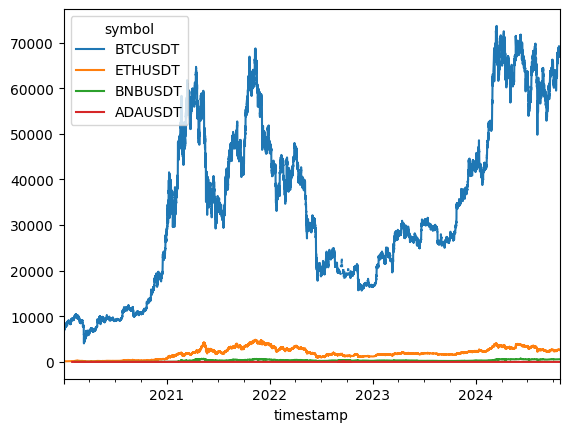

In [5]:
prices.plot()

# in following we will ignore bifurcating dataset into training, validation and testing.  the point of this is to demonstrate overfitting test and risk of scientist cheating on scenarios they give to us

# Objective:  predict the RELATIVE returns of BTC, ETH, BNB and ADA.  
# think of this as predicting Return-Return(equally weighted index of returns)

# Scientist tries some Signal/Indicator/Predictor 

## here we assume he derives his signal from a base class called Indicator.

In [6]:
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import math

def ClassByName(classname):
    cls = globals()[classname]

    return cls()

def IndicatorFactory(config):
    ind=ClassByName(config['type'])
    ind.set_parms(**config['parms'])
    return ind

class Indicator(ABC):

    @abstractmethod
    def set_parms(self, **parms):
        pass

    @abstractmethod
    def predict(self,data):
        pass

class DigitalSmoother(Indicator):

    def __init__(self,window=1,direction=1):
        self._window=window
        self._direction=direction



    def set_parms(self, **parms):
        self._window = parms['window']
        self._direction=parms['direction']



    def predict(self,data):
        #changes retiurns to sign of return
        data1=np.sign(data.pct_change())

        #smooths the sign of returns 
        pred = self._direction=data1.rolling(window=self._window).mean()

        #normalizes so sum of absolute valuies of predictons is 1
        pred=pred.divide(abs(pred).sum(axis=1),axis=0)
        return pred


## config file that specifies a finite discretization of the signal parameter space. 

In [7]:
config={
    "indicator":'MyDigitalSmoother',
    "type":'DigitalSmoother',
    "param_space" : {
        "window": range(1,500),
        "direction":[-1,1]
    

    }
}


In [8]:
def get_predictions(signal,prices):


    predictions=signal.predict(prices)
    #scale predicitons so sum of abs value is 1. this is a quasi normilization.
    predictions=predictions.divide(abs(predictions).sum(axis=1),axis=0)

    
    return predictions

In [9]:
def backtest(assets_returns, relative_return_predictions):
    relative_return_predictions = relative_return_predictions.ffill()
    #the following is closely relatived to measuring the lead lag correlation of the prediction to the outcome.
    pf_returns = assets_returns.mul(relative_return_predictions.shift(1)).sum(axis=1)
    pf_returns.iloc[0] = 0  # first day return is 0, because we do not have weights for yesterday
    return pf_returns

def returns_to_equity(returns):
    equity = returns.add(1).cumprod()
    return equity

# Run backtests for many differnet params  by exhausting reasonable grid of 2 dimensional parameter space of window and direction and get backtest results.

In [10]:


df_pfs_returns = pd.DataFrame()

#for shorti in tqdm(range(1,100,5)):
#    for longi in (range(shorti+1,120,5)):
param_space=config['param_space']
signal_type=config['type']
 
for values in product(*param_space.values()):
    params = {key: val for key, val in zip(param_space.keys(), values)}

    signal = IndicatorFactory({'type':signal_type,'parms':params}) 
  
    
         
 
    _predictions = signal.predict(prices)
    #_weights.fillna(0,inplace=True)


    _pf_returns = backtest(token_returns, _predictions)

    index_str='.'.join(str(x) for x in params.values())

    df_pfs_returns[index_str] = _pf_returns
     


# Plot 10 random results:

<Axes: xlabel='timestamp'>

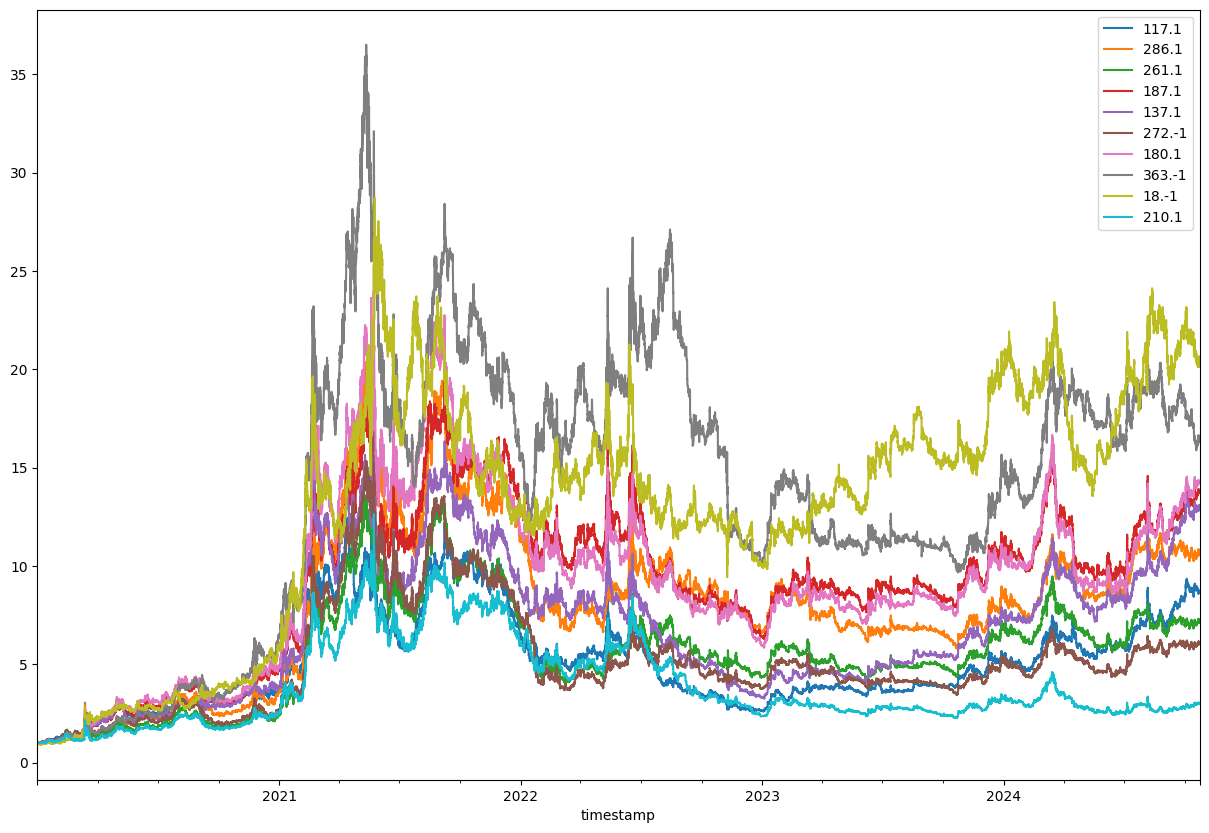

In [11]:
returns_to_equity(df_pfs_returns.sample(n=10, axis=1)).plot(figsize=(15, 10), legend=True)

# Analyze results with PSR

First we are going to look for the portfolios with the highests SRs.

In [12]:
ann_best_srs = ann_estimated_sharpe_ratio(df_pfs_returns).sort_values(ascending=False)
ann_best_srs

479.-1    1.639995
479.1     1.639995
480.1     1.632092
480.-1    1.632092
487.-1    1.631757
            ...   
3.1      -0.945830
1.-1     -1.071925
1.1      -1.071925
2.1      -1.306795
2.-1     -1.306795
Length: 998, dtype: float64

Ohh the signal with window 479 and direction -1 has a  Sharpe Ratio of 1.63!

But now we know that we do not have to look for the signals with the highest SR only. We must look for the signals with a high Probabilistic Sharpe Ratio,
We need to chechk if there is a high probability in that our SR estimation will be true in the future.

Lets calculate the PSR of all the portfolios:

In [13]:
probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0).sort_values(ascending=False)

479.-1    0.999841
479.1     0.999841
480.-1    0.999830
480.1     0.999830
487.-1    0.999829
            ...   
3.-1      0.019737
1.1       0.009750
1.-1      0.009750
2.-1      0.002171
2.1       0.002171
Length: 998, dtype: float64

NICE!
The signal with  window 479 and direction -1  has a very high PSR. Its PSR indicates that there is a probability of 99.64% that the SR of that signal will be greater than 0 (SR benchmark) in the future. It looks great! 

# we want to OWN the following overfitting testing

# Analyze results with DSR (avoid multiple testing problem)

But wait, in the last post we have seen that de PSR only works under the assumption of a single trial. And we have backtested 998 trials!! So we need to calculate de Deflated Sharpe Ratio to correct the inflation of the SR due to our multiple testing.

Lets check the DSR for the signal window 479 and direction -1!

In [14]:
best_psr_pf_name = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0).sort_values(ascending=False).index[0]
best_psr_pf_returns = df_pfs_returns[best_psr_pf_name]

In [15]:
best_psr_pf_name

'479.-1'

<Axes: xlabel='timestamp'>

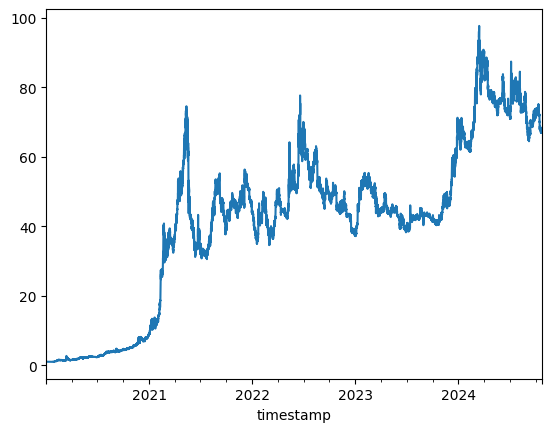

In [16]:
returns_to_equity(best_psr_pf_returns).plot()

Mmmm the euqity curve looks so nice, but what about the DSR?

In [17]:
dsr = deflated_sharpe_ratio(trials_returns=df_pfs_returns, returns_selected=best_psr_pf_returns)
pvalue=1-dsr

In [18]:
print('pvalue is {}%'.format(round(float(pvalue*100),0)))

pvalue is 11.0%


**Oooppps, the Deflated Sharpe Ratio is saying us that statistically we only have 89% chances that our signal has an edge, and can help us give us positive returns in the future.**

**Statistically we do not have a sufficient (95%) level of confidence that our signal have predictive power. Rather, it is quite likely that the good results we have seen in the backtest are the result of overffiting. We have been fooled by randomness!**

### Internal calculations for de DSR accounting for correlation of trials

In [19]:
independent_trials = num_independent_trials(trials_returns=df_pfs_returns)
independent_trials

314

In [20]:
exp_max_sr = expected_maximum_sr(trials_returns=df_pfs_returns, independent_trials=independent_trials)
exp_max_sr

np.float64(0.011576119349429047)

In [21]:
exp_max_sr_annualized = ann_estimated_sharpe_ratio(sr=exp_max_sr)
exp_max_sr_annualized

np.float64(1.083465404765605)

In [22]:
deflated_sharpe_ratio(returns_selected=best_psr_pf_returns, expected_max_sr=exp_max_sr)

np.float64(0.8891405892574971)

# Now, if we did not CONTROL HOW the trials are performed and left it up to the scientist, this is how the scientist could cheat.

## the idea is that overfit signals kind of fill all possible paths, and some might give good results. 
## this is more or less given by how volatile the profit and loss samples from all the trials is.  
## so a bad actor could take the optimal signal and not submit signals with different parameter values, but, rather, 
## take the optimal signal and put just a small amount of noise around the predictions 998 trials.

In [23]:
num_obs=len(df_pfs_returns)
num_trials=len(df_pfs_returns.columns)

In [35]:
small_nums=np.random.normal(0, 0.0005, size=num_obs*num_trials)
small_nums=small_nums.reshape(num_obs,num_trials)
fake=pd.DataFrame(small_nums,index=df_pfs_returns.index,columns=df_pfs_returns.columns)

In [36]:
fake=fake.add(df_pfs_returns[best_psr_pf_name].values,axis=0)

In [39]:
fake[best_psr_pf_name]=best_psr_pf_returns

# note these look a lot closer to each other

<Axes: xlabel='timestamp'>

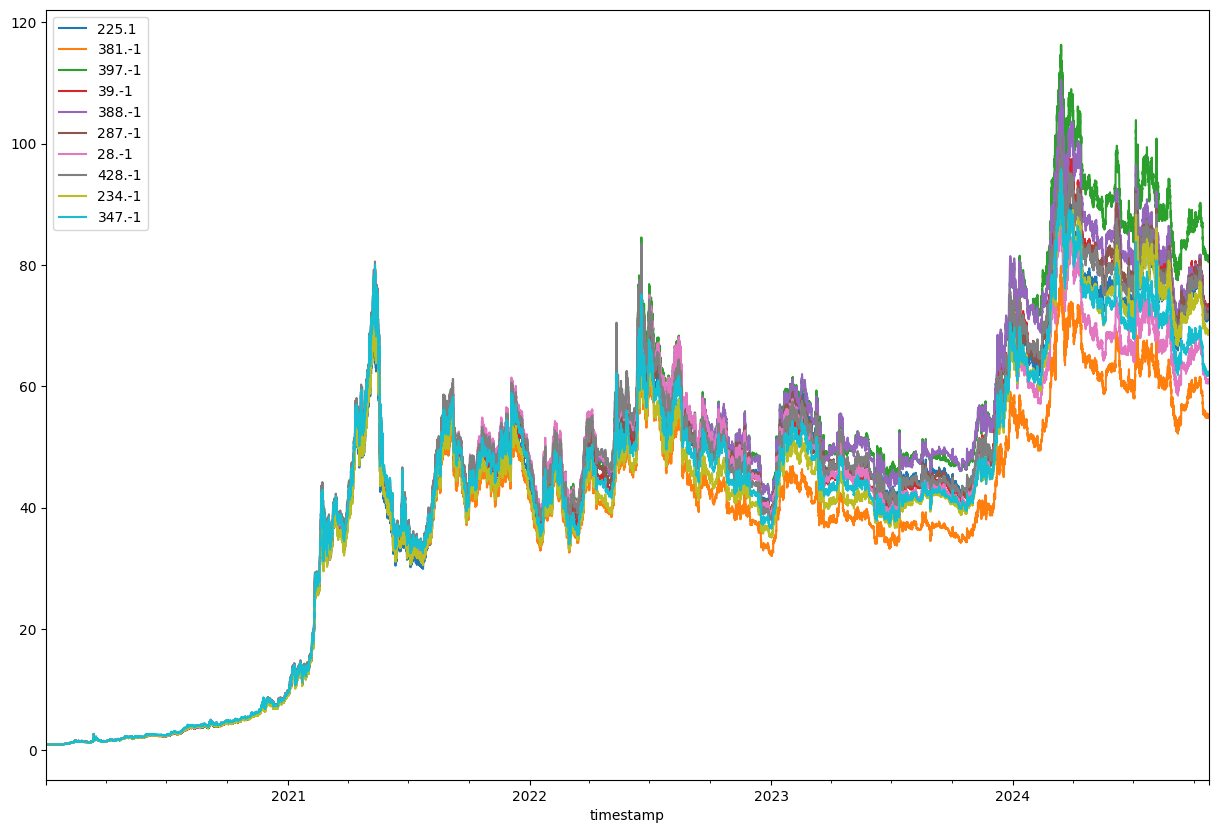

In [40]:
returns_to_equity(fake.sample(n=10, axis=1)).plot(figsize=(15, 10), legend=True)

In [41]:
ann_best_srs = ann_estimated_sharpe_ratio(fake).sort_values(ascending=False)
ann_best_srs


335.-1    1.735427
208.1     1.726674
228.1     1.724464
87.1      1.720454
145.-1    1.714657
            ...   
58.1      1.550562
249.-1    1.550235
162.-1    1.549591
120.1     1.537644
107.-1    1.535755
Length: 998, dtype: float64

In [43]:
best_psr_pf_name = probabilistic_sharpe_ratio(returns=fake, sr_benchmark=0).sort_values(ascending=False).index[0]
best_psr_pf_returns = df_pfs_returns[best_psr_pf_name]

In [44]:
best_psr_pf_returns

timestamp
2020-01-01 01:00:00    0.000000
2020-01-01 02:00:00    0.000000
2020-01-01 03:00:00    0.000000
2020-01-01 04:00:00    0.000000
2020-01-01 05:00:00    0.000000
                         ...   
2024-10-23 02:00:00    0.001175
2024-10-23 03:00:00   -0.002495
2024-10-23 04:00:00   -0.000514
2024-10-23 05:00:00    0.000729
2024-10-23 06:00:00   -0.000583
Name: 335.-1, Length: 42174, dtype: float64

In [45]:
dsr = deflated_sharpe_ratio(trials_returns=fake, returns_selected=best_psr_pf_returns)
pvalue=1-dsr

In [47]:
print('fuck, the p-value is {}%. so the bad actor fooled us'.format(round(float(pvalue*100),0)))

fuck, the p-value is 1.0%. so the bad actor fooled us
